# 1. Imports

In [1]:
import os, json, cv2, numpy as np, matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F
from torchvision.transforms import transforms as transforms

# Library for augmentations
import albumentations as A

# https://github.com/pytorch/vision/tree/main/references/detection
import transforms, utils, engine, train
from utils import collate_fn
from engine import train_one_epoch, evaluate

# 2. Augmentations

In [2]:
def train_transform(rotate: bool=True):
    funcs = []
    
    # Random change of brightness and contrast
    funcs.append(A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, brightness_by_max=True, always_apply=False, p=1))
    
    if rotate:
        # Random rotation
        funcs.append(A.augmentations.geometric.rotate.Rotate(limit=10, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=1))
    
        ret = A.Compose([A.Sequential(funcs, p=1)], keypoint_params=A.KeypointParams(format='xy'),
              bbox_params=A.BboxParams(format='pascal_voc', label_fields=['bboxes_labels']))
    
    else:
        ret = A.Compose([A.Sequential(funcs, p=1)], )
    
    return ret

# 3. Dataset class

In [3]:
class ClassDataset(Dataset):
    def __init__(self, images: list, annotations: list, transform=None, demo=False, filenames=None):                
        #self.root = root
        self.transform = transform
        # Use demo=True if you need transformed and original images (visualization purposes)
        self.demo = demo
        self.images = images
        self.annotations = annotations
        # If filenames are set, it will be printed when image is accessed (logging purposes)
        self.filenames = filenames
    
    def __getitem__(self, idx):
        img_original = self.images[idx]
        bboxes_original = self.annotations[idx]['bboxes']
        keypoints_original = self.annotations[idx]['keypoints']
        bboxes_labels_original = ['Car wheel' for _ in bboxes_original]           

        if self.transform:   
            # Converting keypoints from [x, y, visibility]-format to [x, y]-format + Flattening nested list of keypoints 
            keypoints_original_flattened = [el[0:2] for kp in keypoints_original for el in kp]

            # Apply augmentations (while loop to retry different rotation if a rotation crops away a keypoint)
            keypoints = []
            while len(keypoints) != len(keypoints_original_flattened):
                transform = self.transform(rotate=True)
                # Try-except block because some bboxes get mangled in the transformation process (negative width or height)
                try:
                    transformed = transform(image=img_original, bboxes=bboxes_original, bboxes_labels=bboxes_labels_original, keypoints=keypoints_original_flattened)
                except ValueError:
                    transform = self.transform(rotate=False)
                    transformed = transform(image=img_original)
                    transformed['bboxes'] = bboxes_original
                    transformed['keypoints'] = keypoints_original_flattened

                img = transformed['image']
                bboxes = transformed['bboxes']
                keypoints = transformed['keypoints']
            
            if self.filenames:
                print(self.filenames[idx])
            
            # Unflattening [[x, y], [x, y], ...] keypoints into [[[x, y], [x, y], [x, y], [x, y], [x, y]], [...], [...]]
            keypoints_transformed_unflattened = np.reshape(np.array(keypoints), (-1, 5, 2)).tolist()

            # Converting transformed keypoints from [x, y]-format to [x, y, visibility]-format by appending original visibilities to transformed coordinates of keypoints
            keypoints = []
            for o_idx, obj in enumerate(keypoints_transformed_unflattened):
                obj_keypoints = []
                for k_idx, kp in enumerate(obj): # Iterating over keypoints in each object
                    # kp - coordinates of keypoint
                    # keypoints_original[o_idx][k_idx][2] - original visibility of keypoint
                    obj_keypoints.append(kp + [keypoints_original[o_idx][k_idx][2]])
                keypoints.append(obj_keypoints)
                
        # No transformation
        else:
            img, bboxes, keypoints = img_original, bboxes_original, keypoints_original        
        
        # Convert everything into a torch tensor        
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)       
        target = {}
        target['boxes'] = bboxes
        # All objects are car wheels
        target['labels'] = torch.as_tensor([1 for _ in bboxes], dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])
        target['area'] = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        target['iscrowd'] = torch.zeros(len(bboxes), dtype=torch.int64)
        target['keypoints'] = torch.as_tensor(keypoints, dtype=torch.float32)        
        img = F.to_tensor(img)
        
        bboxes_original = torch.as_tensor(bboxes_original, dtype=torch.float32)
        target_original = {}
        target_original['boxes'] = bboxes_original
        # All objects are car wheels
        target_original['labels'] = torch.as_tensor([1 for _ in bboxes_original], dtype=torch.int64)
        target_original['image_id'] = torch.tensor([idx])
        target_original['area'] = (bboxes_original[:, 3] - bboxes_original[:, 1]) * (bboxes_original[:, 2] - bboxes_original[:, 0])
        target_original['iscrowd'] = torch.zeros(len(bboxes_original), dtype=torch.int64)
        target_original['keypoints'] = torch.as_tensor(keypoints_original, dtype=torch.float32)        
        img_original = F.to_tensor(img_original)

        if self.demo:
            return img, target, img_original, target_original
        else:
            return img, target
    
    def __len__(self):
        return len(self.images)

# 4. Visualizing a random item from dataset

In [4]:
keypoints_classes_ids2names = {0: 'Top', 1: 'Bottom', 2: 'Right', 3: 'Sidewall', 4: 'Width'}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    if image_original is not None:
        image_original = cv2.cvtColor(image_original, cv2.COLOR_GRAY2RGB)

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, ' ' + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

In [5]:
def load_dataset():

    path_to_images = 'dataset/images'
    path_to_annotations = 'dataset/annotations'

    image_filenames = sorted(os.listdir(path_to_images))
    images = [cv2.imread(os.path.join(path_to_images, file), cv2.IMREAD_GRAYSCALE) for file in image_filenames]

    annotation_filenames = sorted(os.listdir(path_to_annotations))
    annotations = []
    for file in annotation_filenames:
        with open(os.path.join(path_to_annotations, file), 'r') as annotation:
            annotations.append(json.load(annotation))
    
    return images, annotations, image_filenames

2_018.jpg


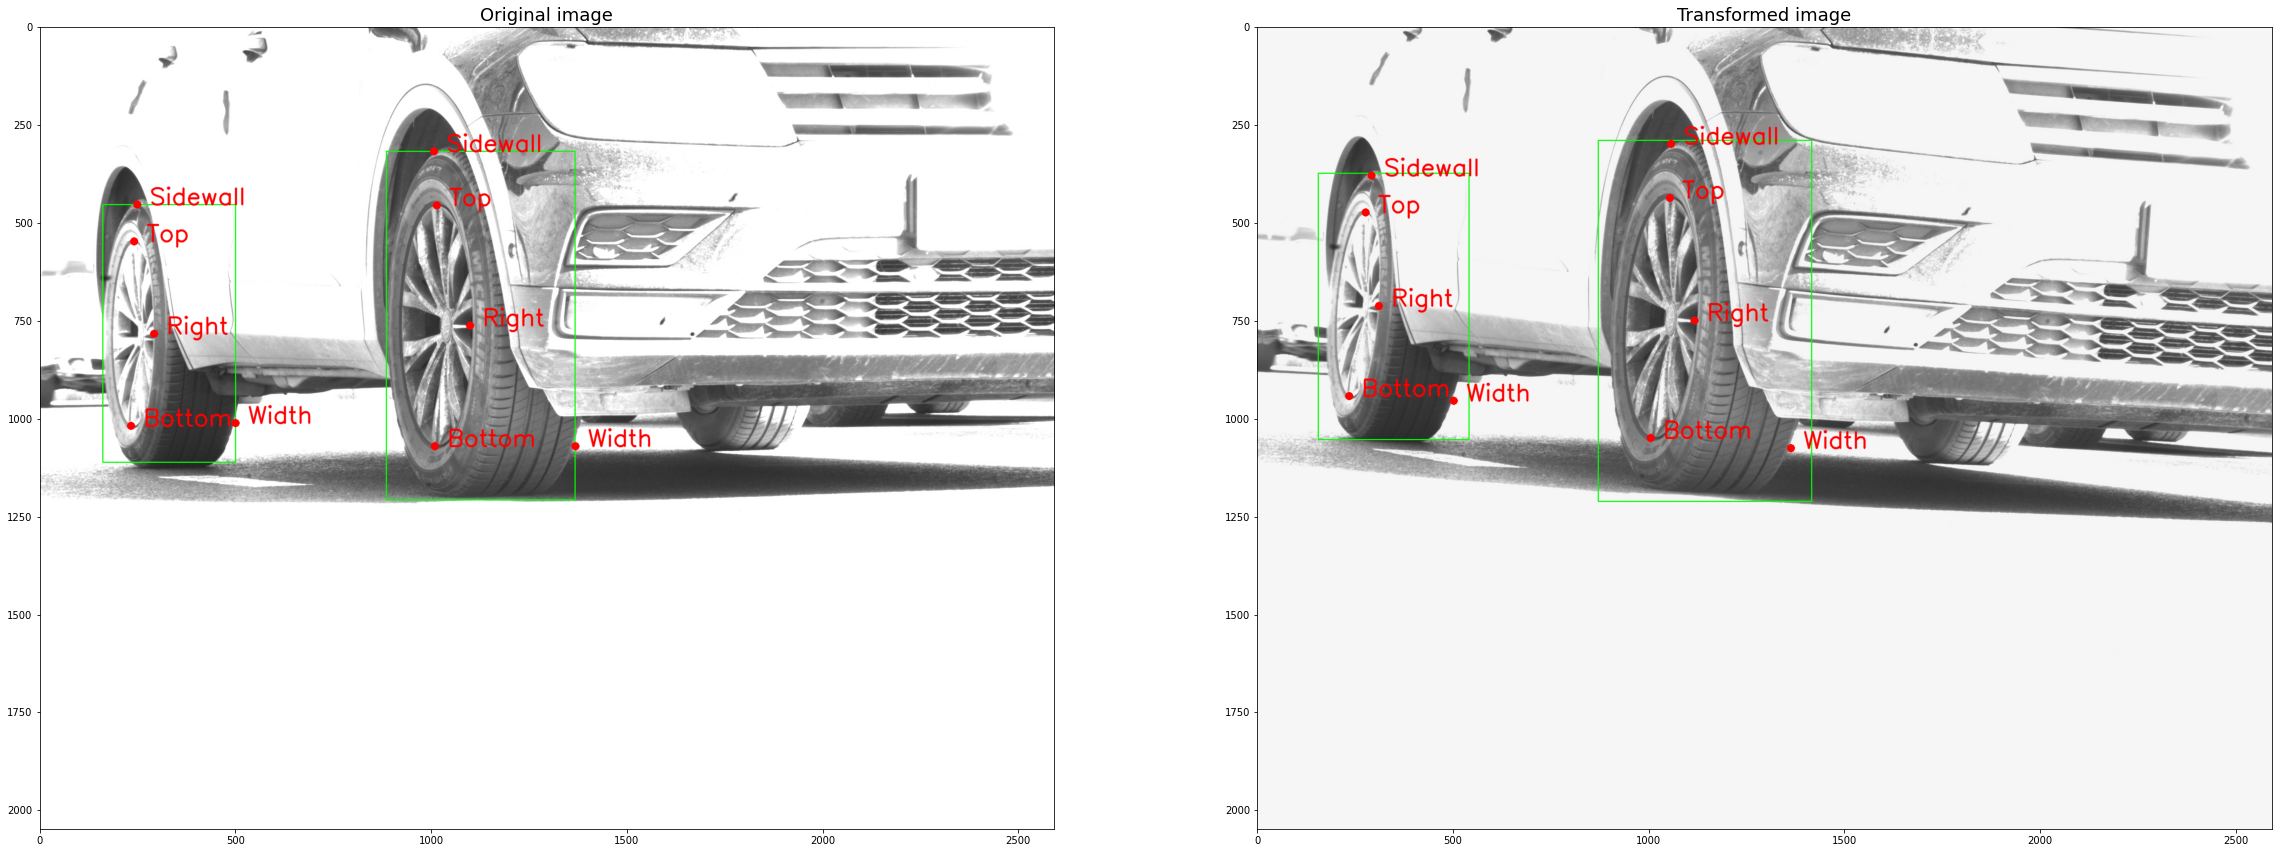

In [7]:
images, annotations, filenames = load_dataset()

dataset = ClassDataset(images, annotations, transform=train_transform, demo=True, filenames=filenames)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

iterator = iter(data_loader)
batch = next(iterator)

image = (batch[0][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
bboxes = batch[1][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints = []
for kps in batch[1][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints.append([kp[:2] for kp in kps])

image_original = (batch[2][0].permute(1, 2, 0).numpy() * 255).astype(np.uint8)
bboxes_original = batch[3][0]['boxes'].detach().cpu().numpy().astype(np.int32).tolist()

keypoints_original = []
for kps in batch[3][0]['keypoints'].detach().cpu().numpy().astype(np.int32).tolist():
    keypoints_original.append([kp[:2] for kp in kps])

visualize(image, bboxes, keypoints, image_original, bboxes_original, keypoints_original)

# 5. Training

In [8]:
def get_model(num_keypoints, weights_path=None):
    # Aspect ratio = width / height
    # We know that car tires will always fit in: 1 <= aspect ratio <= 2 
    # Though upper bound depends on minimum angle of attack, which on this dataset is something like 20 degrees
    # Basically the tire will never be captured from the front anyway, in which case the aspect ratio might be something like 3
    anchor_generator = AnchorGenerator(sizes=(100, 250, 400, 650, 800), 
                                       aspect_ratios=(1.0, 1.25, 1.5, 1.75, 2.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   # One class for car wheel, one class for background
                                                                   num_classes=2,
                                                                   rpn_anchor_generator=anchor_generator)
    if weights_path:
        state_dict = torch.load(weights_path)
        model.load_state_dict(state_dict)        
        
    return model

In [16]:
def test_train_split_indexes(dataset_length: int, train_size: float=0.8, seed: int=None):
    """
    Split indexes of array into train/test
    
    [0, 1, 2, 3, 4, 5] => [0, 2, 3, 5], [1, 4]
    """
    
    if not 0 < train_size <= 1:
        raise ValueError('Invalid train size (must be between 0 and 1, 80/20 would be 0.8 train_size,)')
    
    if seed is not None:
        np.random.seed(seed)
        
    indexes = np.indices([dataset_length])[0]
    np.random.shuffle(indexes)
    np.random.seed()
    
    train_size = int(round(dataset_length * train_size, 0))
    train_indexes = indexes[:train_size]
    test_indexes = indexes[train_size:]
    train_indexes.sort()
    test_indexes.sort()
    
    return train_indexes.tolist(), test_indexes.tolist()

def test_train_split(dataset: list, train_size: float=0.8, seed: int=None):
    """Split dataset into training and testing datasets"""
    
    train_indexes, test_indexes = test_train_split_indexes(len(dataset), train_size, seed)
    
    train = []
    test = []
    
    for train_index in train_indexes:
        train.append(dataset[train_index])
    for test_index in test_indexes:
        test.append(dataset[test_index])
        
    return train, test

# Load dataset
images, annotations, filenames = load_dataset()

# Split into train and test datasets with 66/34 split
seed = 666
train_size = 0.66
train_images, test_images = test_train_split(images, train_size, seed)
train_annotations, test_annotations = test_train_split(annotations, train_size, seed)
train_filenames, test_filenames = test_train_split(filenames, train_size, seed)

In [9]:
# Create objects used by PyTorch, add transformation function to train data (artificial diversity)
dataset_train = ClassDataset(train_images, train_annotations, transform=train_transform, demo=False)
dataset_test = ClassDataset(test_images, test_annotations, transform=None, demo=False)

data_loader_train = DataLoader(dataset_train, batch_size=1, shuffle=True, collate_fn=collate_fn)
data_loader_test = DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=collate_fn)

# Prepare model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_keypoints=5)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.3)
num_epochs = 30

# Training
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=100)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device)
    
# Save model after training
torch.save(model.state_dict(), 'saved_model_final.pth')

/home/daniel/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch: [0]  [  0/100]  eta: 0:00:22  lr: 0.000011  loss: 9.6755 (9.6755)  loss_classifier: 0.7451 (0.7451)  loss_box_reg: 0.0475 (0.0475)  loss_keypoint: 8.0680 (8.0680)  loss_objectness: 0.7037 (0.7037)  loss_rpn_box_reg: 0.1111 (0.1111)  time: 0.2229  data: 0.0209  max mem: 1020
Epoch: [0]  [ 99/100]  eta: 0:00:00  lr: 0.001000  loss: 6.8707 (8.0274)  loss_classifier: 0.1943 (0.3727)  loss_box_reg: 0.2691 (0.1862)  loss_keypoint: 5.8181 (6.7189)  loss_objectness: 0.3556 (0.5931)  loss_rpn_box_reg: 0.1419 (0.1565)  time: 0.2319  data: 0.0197  max mem: 1626
Epoch: [0] Total time: 0:00:22 (0.2238 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0908 (0.0908)  evaluator_time: 0.0029 (0.0029)  time: 0.1108  data: 0.0134  max mem: 1626
Test:  [50/51]  eta: 0:00:00  model_time: 0.0919 (0.0928)  evaluator_time: 0.0042 (0.0043)  time: 0.1128  data: 0.0121  max mem: 1626
Test: Total time: 0:00:05 (0.1135 s / it)
Averaged stats: model_time: 0.0919 (0.0928)  e

Epoch: [3]  [  0/100]  eta: 0:00:27  lr: 0.001000  loss: 3.5940 (3.5940)  loss_classifier: 0.1479 (0.1479)  loss_box_reg: 0.1199 (0.1199)  loss_keypoint: 3.1459 (3.1459)  loss_objectness: 0.1198 (0.1198)  loss_rpn_box_reg: 0.0604 (0.0604)  time: 0.2781  data: 0.0304  max mem: 1644
Epoch: [3]  [ 99/100]  eta: 0:00:00  lr: 0.001000  loss: 3.8569 (4.1355)  loss_classifier: 0.0665 (0.0835)  loss_box_reg: 0.0840 (0.1068)  loss_keypoint: 3.5916 (3.7675)  loss_objectness: 0.0493 (0.0767)  loss_rpn_box_reg: 0.0981 (0.1010)  time: 0.2449  data: 0.0193  max mem: 1644
Epoch: [3] Total time: 0:00:24 (0.2429 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0789 (0.0789)  evaluator_time: 0.0016 (0.0016)  time: 0.1060  data: 0.0204  max mem: 1644
Test:  [50/51]  eta: 0:00:00  model_time: 0.0781 (0.0787)  evaluator_time: 0.0020 (0.0020)  time: 0.0986  data: 0.0149  max mem: 1644
Test: Total time: 0:00:05 (0.0999 s / it)
Averaged stats: model_time: 0.0781 (0.0787)  e

Epoch: [6]  [  0/100]  eta: 0:00:25  lr: 0.000300  loss: 3.2596 (3.2596)  loss_classifier: 0.0455 (0.0455)  loss_box_reg: 0.0851 (0.0851)  loss_keypoint: 3.0097 (3.0097)  loss_objectness: 0.0544 (0.0544)  loss_rpn_box_reg: 0.0650 (0.0650)  time: 0.2586  data: 0.0245  max mem: 1644
Epoch: [6]  [ 99/100]  eta: 0:00:00  lr: 0.000300  loss: 2.8514 (2.9421)  loss_classifier: 0.0428 (0.0513)  loss_box_reg: 0.0823 (0.0712)  loss_keypoint: 2.6976 (2.7255)  loss_objectness: 0.0326 (0.0325)  loss_rpn_box_reg: 0.0510 (0.0617)  time: 0.2511  data: 0.0192  max mem: 1704
Epoch: [6] Total time: 0:00:25 (0.2541 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0753 (0.0753)  evaluator_time: 0.0013 (0.0013)  time: 0.0931  data: 0.0130  max mem: 1704
Test:  [50/51]  eta: 0:00:00  model_time: 0.0768 (0.0768)  evaluator_time: 0.0016 (0.0017)  time: 0.0939  data: 0.0117  max mem: 1704
Test: Total time: 0:00:04 (0.0956 s / it)
Averaged stats: model_time: 0.0768 (0.0768)  e

Epoch: [9]  [  0/100]  eta: 0:00:24  lr: 0.000300  loss: 2.4762 (2.4762)  loss_classifier: 0.0305 (0.0305)  loss_box_reg: 0.0333 (0.0333)  loss_keypoint: 2.3802 (2.3802)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0230 (0.0230)  time: 0.2427  data: 0.0278  max mem: 1710
Epoch: [9]  [ 99/100]  eta: 0:00:00  lr: 0.000300  loss: 2.4169 (2.6577)  loss_classifier: 0.0322 (0.0435)  loss_box_reg: 0.0549 (0.0656)  loss_keypoint: 2.2579 (2.4623)  loss_objectness: 0.0160 (0.0266)  loss_rpn_box_reg: 0.0472 (0.0597)  time: 0.2611  data: 0.0225  max mem: 1710
Epoch: [9] Total time: 0:00:25 (0.2540 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0752 (0.0752)  evaluator_time: 0.0012 (0.0012)  time: 0.0979  data: 0.0181  max mem: 1710
Test:  [50/51]  eta: 0:00:00  model_time: 0.0767 (0.0762)  evaluator_time: 0.0015 (0.0016)  time: 0.0946  data: 0.0129  max mem: 1710
Test: Total time: 0:00:04 (0.0954 s / it)
Averaged stats: model_time: 0.0767 (0.0762)  e

Epoch: [12]  [  0/100]  eta: 0:00:24  lr: 0.000090  loss: 2.7831 (2.7831)  loss_classifier: 0.0568 (0.0568)  loss_box_reg: 0.1118 (0.1118)  loss_keypoint: 2.5172 (2.5172)  loss_objectness: 0.0069 (0.0069)  loss_rpn_box_reg: 0.0904 (0.0904)  time: 0.2422  data: 0.0222  max mem: 1728
Epoch: [12]  [ 99/100]  eta: 0:00:00  lr: 0.000090  loss: 2.2264 (2.3324)  loss_classifier: 0.0309 (0.0398)  loss_box_reg: 0.0563 (0.0599)  loss_keypoint: 2.1090 (2.1601)  loss_objectness: 0.0136 (0.0220)  loss_rpn_box_reg: 0.0441 (0.0506)  time: 0.2498  data: 0.0192  max mem: 1728
Epoch: [12] Total time: 0:00:25 (0.2532 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0763 (0.0763)  evaluator_time: 0.0013 (0.0013)  time: 0.0986  data: 0.0171  max mem: 1728
Test:  [50/51]  eta: 0:00:00  model_time: 0.0774 (0.0767)  evaluator_time: 0.0015 (0.0016)  time: 0.0958  data: 0.0136  max mem: 1728
Test: Total time: 0:00:04 (0.0963 s / it)
Averaged stats: model_time: 0.0774 (0.0767)

Epoch: [15]  [  0/100]  eta: 0:00:26  lr: 0.000027  loss: 2.5604 (2.5604)  loss_classifier: 0.0899 (0.0899)  loss_box_reg: 0.0557 (0.0557)  loss_keypoint: 2.3459 (2.3459)  loss_objectness: 0.0258 (0.0258)  loss_rpn_box_reg: 0.0430 (0.0430)  time: 0.2645  data: 0.0280  max mem: 1728
Epoch: [15]  [ 99/100]  eta: 0:00:00  lr: 0.000027  loss: 2.3932 (2.1716)  loss_classifier: 0.0327 (0.0395)  loss_box_reg: 0.0589 (0.0578)  loss_keypoint: 2.2125 (2.0100)  loss_objectness: 0.0236 (0.0223)  loss_rpn_box_reg: 0.0474 (0.0420)  time: 0.2658  data: 0.0207  max mem: 1728
Epoch: [15] Total time: 0:00:25 (0.2556 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0757 (0.0757)  evaluator_time: 0.0011 (0.0011)  time: 0.0978  data: 0.0174  max mem: 1728
Test:  [50/51]  eta: 0:00:00  model_time: 0.0760 (0.0762)  evaluator_time: 0.0015 (0.0016)  time: 0.0951  data: 0.0137  max mem: 1728
Test: Total time: 0:00:04 (0.0954 s / it)
Averaged stats: model_time: 0.0760 (0.0762)

Epoch: [18]  [  0/100]  eta: 0:00:26  lr: 0.000027  loss: 1.6636 (1.6636)  loss_classifier: 0.0341 (0.0341)  loss_box_reg: 0.0360 (0.0360)  loss_keypoint: 1.5615 (1.5615)  loss_objectness: 0.0037 (0.0037)  loss_rpn_box_reg: 0.0283 (0.0283)  time: 0.2637  data: 0.0270  max mem: 1728
Epoch: [18]  [ 99/100]  eta: 0:00:00  lr: 0.000027  loss: 2.0660 (2.0876)  loss_classifier: 0.0314 (0.0392)  loss_box_reg: 0.0473 (0.0577)  loss_keypoint: 1.8961 (1.9340)  loss_objectness: 0.0131 (0.0168)  loss_rpn_box_reg: 0.0350 (0.0398)  time: 0.2619  data: 0.0219  max mem: 1728
Epoch: [18] Total time: 0:00:26 (0.2631 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:05  model_time: 0.0760 (0.0760)  evaluator_time: 0.0011 (0.0011)  time: 0.0996  data: 0.0189  max mem: 1728
Test:  [50/51]  eta: 0:00:00  model_time: 0.0761 (0.0763)  evaluator_time: 0.0015 (0.0016)  time: 0.0964  data: 0.0145  max mem: 1728
Test: Total time: 0:00:04 (0.0963 s / it)
Averaged stats: model_time: 0.0761 (0.0763)

Epoch: [21]  [  0/100]  eta: 0:00:29  lr: 0.000008  loss: 2.1854 (2.1854)  loss_classifier: 0.0624 (0.0624)  loss_box_reg: 0.0906 (0.0906)  loss_keypoint: 1.9967 (1.9967)  loss_objectness: 0.0087 (0.0087)  loss_rpn_box_reg: 0.0270 (0.0270)  time: 0.2942  data: 0.0227  max mem: 1728
Epoch: [21]  [ 99/100]  eta: 0:00:00  lr: 0.000008  loss: 1.8017 (2.0260)  loss_classifier: 0.0304 (0.0371)  loss_box_reg: 0.0438 (0.0527)  loss_keypoint: 1.7181 (1.8813)  loss_objectness: 0.0107 (0.0180)  loss_rpn_box_reg: 0.0288 (0.0370)  time: 0.2545  data: 0.0206  max mem: 1728
Epoch: [21] Total time: 0:00:26 (0.2605 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0761 (0.0761)  evaluator_time: 0.0012 (0.0012)  time: 0.0976  data: 0.0167  max mem: 1728
Test:  [50/51]  eta: 0:00:00  model_time: 0.0762 (0.0762)  evaluator_time: 0.0016 (0.0016)  time: 0.0943  data: 0.0124  max mem: 1728
Test: Total time: 0:00:04 (0.0954 s / it)
Averaged stats: model_time: 0.0762 (0.0762)

Epoch: [24]  [  0/100]  eta: 0:00:26  lr: 0.000008  loss: 1.5006 (1.5006)  loss_classifier: 0.0395 (0.0395)  loss_box_reg: 0.0552 (0.0552)  loss_keypoint: 1.3728 (1.3728)  loss_objectness: 0.0085 (0.0085)  loss_rpn_box_reg: 0.0247 (0.0247)  time: 0.2661  data: 0.0153  max mem: 1728
Epoch: [24]  [ 99/100]  eta: 0:00:00  lr: 0.000008  loss: 1.9892 (2.0255)  loss_classifier: 0.0338 (0.0352)  loss_box_reg: 0.0527 (0.0543)  loss_keypoint: 1.8867 (1.8832)  loss_objectness: 0.0118 (0.0165)  loss_rpn_box_reg: 0.0371 (0.0363)  time: 0.2615  data: 0.0191  max mem: 1728
Epoch: [24] Total time: 0:00:25 (0.2563 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0752 (0.0752)  evaluator_time: 0.0011 (0.0011)  time: 0.0961  data: 0.0163  max mem: 1728
Test:  [50/51]  eta: 0:00:00  model_time: 0.0771 (0.0767)  evaluator_time: 0.0015 (0.0016)  time: 0.0939  data: 0.0120  max mem: 1728
Test: Total time: 0:00:04 (0.0958 s / it)
Averaged stats: model_time: 0.0771 (0.0767)

Epoch: [27]  [  0/100]  eta: 0:00:26  lr: 0.000002  loss: 3.0604 (3.0604)  loss_classifier: 0.0345 (0.0345)  loss_box_reg: 0.0687 (0.0687)  loss_keypoint: 2.8970 (2.8970)  loss_objectness: 0.0066 (0.0066)  loss_rpn_box_reg: 0.0536 (0.0536)  time: 0.2667  data: 0.0248  max mem: 1728
Epoch: [27]  [ 99/100]  eta: 0:00:00  lr: 0.000002  loss: 1.9764 (2.0329)  loss_classifier: 0.0270 (0.0363)  loss_box_reg: 0.0433 (0.0530)  loss_keypoint: 1.8515 (1.8903)  loss_objectness: 0.0111 (0.0169)  loss_rpn_box_reg: 0.0316 (0.0364)  time: 0.2665  data: 0.0190  max mem: 1728
Epoch: [27] Total time: 0:00:25 (0.2599 s / it)
creating index...
index created!
Test:  [ 0/51]  eta: 0:00:04  model_time: 0.0749 (0.0749)  evaluator_time: 0.0011 (0.0011)  time: 0.0929  data: 0.0134  max mem: 1728
Test:  [50/51]  eta: 0:00:00  model_time: 0.0770 (0.0763)  evaluator_time: 0.0015 (0.0016)  time: 0.0941  data: 0.0123  max mem: 1728
Test: Total time: 0:00:04 (0.0937 s / it)
Averaged stats: model_time: 0.0770 (0.0763)

# 6. Using the model for prediction

In [59]:
# Load model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_keypoints=5)
model.to(device)

model.load_state_dict(torch.load('saved_model.pth', map_location=device))
model.eval()

# For hooks in later cells
handle = None

In [60]:
def predict(original_image: np.ndarray):
    # Convert to tensor
    image = F.to_tensor(original_image)
    # Add batch dimension
    image = image.unsqueeze(0).to(device)

    # Turn off context manager for gradient calculation (memory saving)
    with torch.no_grad():
        output = model(image)

    scores = output[0]['scores'].detach().cpu().numpy()

    if len(scores) == 0:
        print('No hits')
    else:
        # Detections are sorted by score, highest is first
        best = 0
        print(f'Confidence: {scores[best]:.2f}')
        # If you desire to find multiple car wheels, not just the best one, then you have to use NMS to eliminate
        # overlapping objects (because second best object might be referring to the same car wheel, just with less
        # confidence), see https://pytorch.org/vision/main/generated/torchvision.ops.nms.html

        # Get keypoints and bounding box from output
        keypoints = []
        for point in output[0]['keypoints'][best].detach().cpu().numpy():
            keypoints.append([int(point[0]), int(point[1])])

        bbox = [int(i) for i in output[0]['boxes'][best].detach().cpu().numpy()]

        visualize(original_image, [bbox], [keypoints])

## 6.1 Feature maps

In [149]:
# Remove previos hook (useful when you're coming back to this cell)
if handle is not None:
    handle.remove()

# Clear list
feature_maps = []

def hook_feat_map(mod, inp, out):
    feature_maps.append(out)

# Register a hook to a given layer (layers are described in the output of the cell where model is loaded)
layer = 'rpn.head.conv'
handle = model.get_submodule(layer).register_forward_hook(hook_feat_map)

print(handle)

Confidence: 1.00


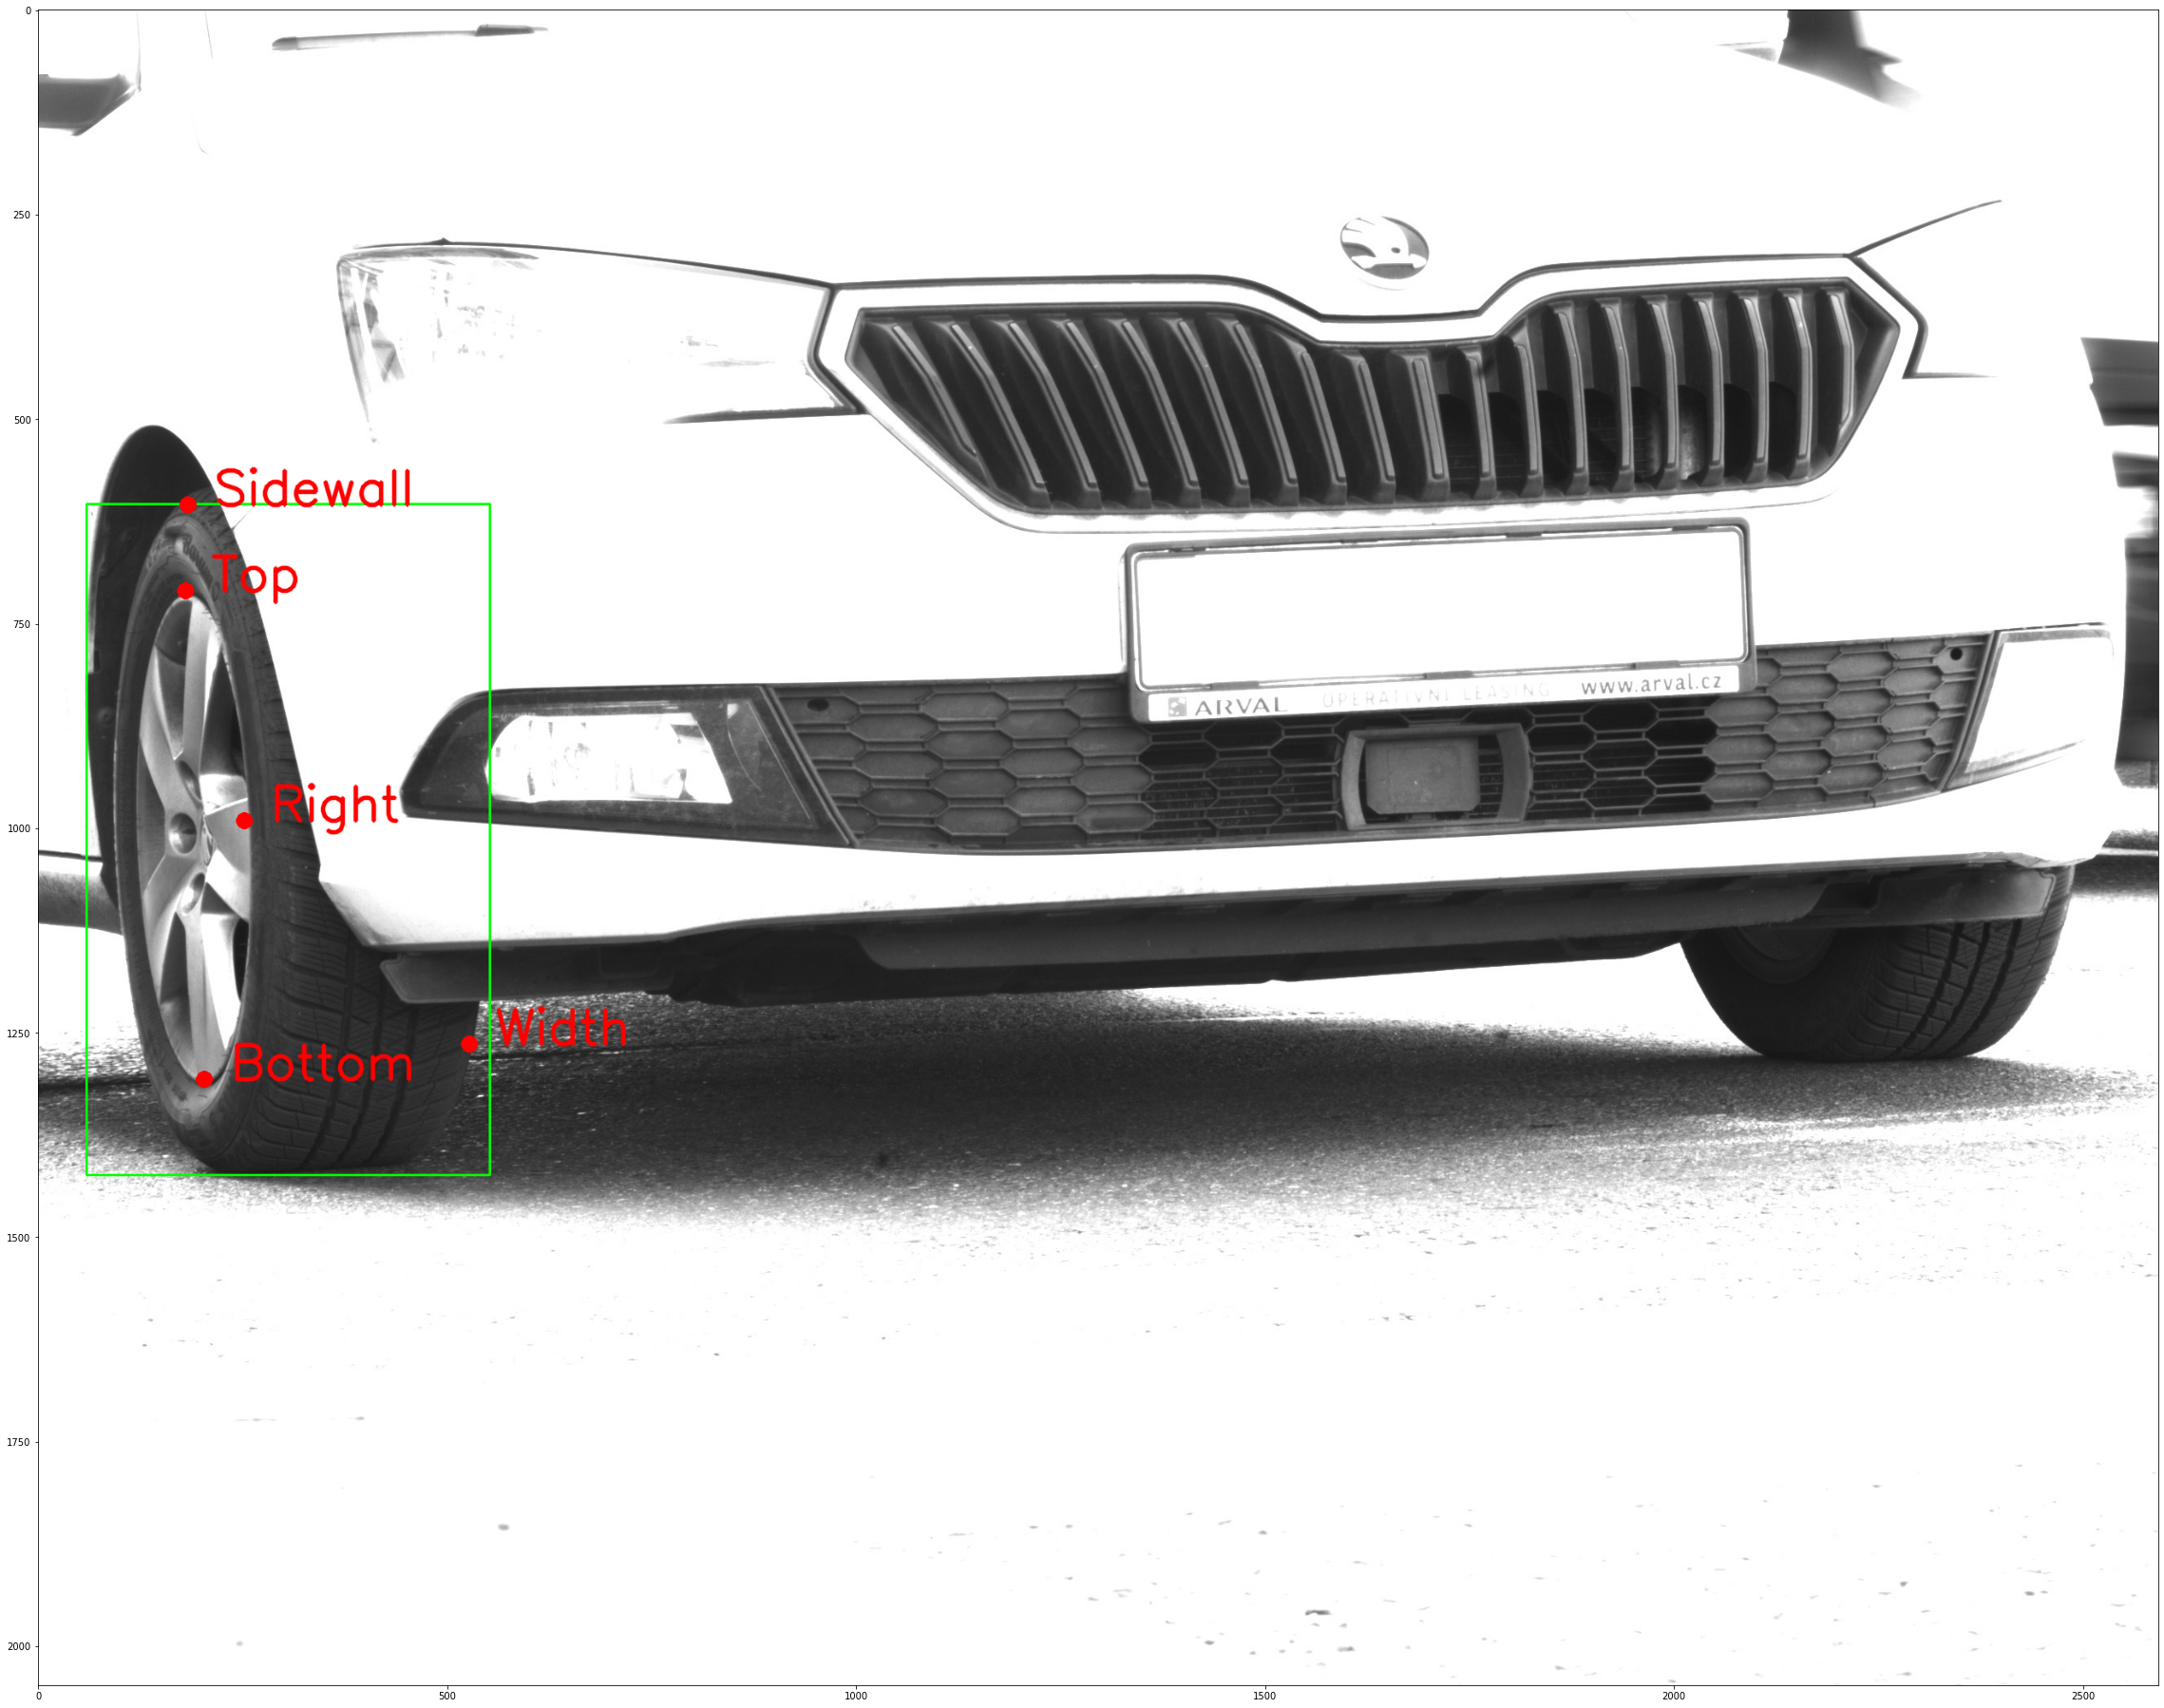

In [150]:
# Forward an image
predict(test_images[4])

In [151]:
# Analyze feature maps (some might be hidden behind an OrderdDict etc.), depending on the layer
print(len(feature_maps[0].detach().cpu().numpy()[0]))
print(feature_maps[0].detach().cpu().numpy()[0][0].shape)

256
(200, 256)


In [152]:
import cv2
import os

# Save all feature maps of this layer in a folder
folder = f'my_path/feature_maps/{layer}'

if not os.path.exists(folder):
    os.makedirs(folder)

i = 0
for feature_map in feature_maps[0].detach().cpu().numpy()[0]:
    # Convert float32 image to uint8
    feature_map = cv2.normalize(feature_map, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    # Save to disk
    cv2.imwrite(f'{folder}/{i}.jpg', feature_map)
    i += 1